# Проектная работа: Выбор локации для скважины

## Описание проекта

Добывающей компании «ГлавРосГосНефть» необходимо решить, где бурить новую скважину. Локация обычно выбирается на основе следующих шагов:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. 

**Целью** проектной работы является выявление региона, который наилучшим образом подходит для бурения новой скважины.

**Задачами** проектной работы являются:
- построение модели для определения региона, где добыча принесёт наибольшую прибыль; 
- анализ возможной прибыли;
- анализ рисков техникой Bootstrap.

**Описание данных:**
- Обучающие признаки:
    - `id` - уникальный идентификатор скважины;
    - `f0`, `f1`, `f2` - три признака точек (неважно, что они означают, но сами признаки значимы);
- Целевой признак:
    - `product` - объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые);
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
- Бюджет на разработку скважин в регионе — 10 млрд рублей;
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей;
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**План проектной работы:**
1. Загрузка и подготовка данных;
2. Обучение и проверка моделей для каждого региона;
3. Подготовительная работа к расчёту прибыли;
4. Написание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели;
5. Рассчет рисков и прибыли для каждого региона;
6. Выводы.

### Шаг 1.  Открытие таблиц и изучение общей информации о данных

In [1]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler



%matplotlib inline

In [2]:
# считываем все данные
df1 = pd.read_csv("geo_data_0.csv")
df2 = pd.read_csv("geo_data_1.csv")
df3 = pd.read_csv("geo_data_2.csv")

Так как нам необходимо изучить три региона, то одни и те же действия придется проделывать трижды. По этой причине напишем функцию, которую можно будет применить ко всем датасетам. Функция `primary_analysis` достаточно простая, с ее помощью можно будет вызвать инструменты первичного анализа и сделать выводы. 

In [3]:
def primary_analysis(df):
    print("Первые пять строчек датафрема:")
    display(df.head())
    print()
    print("Размерность датафрейма:")
    display(df.shape)
    print()
    print("Типы данных в столбцах датафрейма:")
    display(df.dtypes)
    print()
    print("Сводная информация о датафрейме:")
    display(df.info())
    print()
    print("Количество дубликатов в датафрейме:")
    display(df.duplicated().sum())
    print()
    print("Описательная статистика о датафрейме:")
    display(df.describe(percentiles = [0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T)
    print()
    print("Корреляция между столбцами датафрейма:")
    correlation = df.corr()
    triangle = np.triu(correlation)
    plt.figure(figsize = (8, 4))
    sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels = correlation.columns, 
                cmap = "RdBu", center = 0, annot = True, mask = triangle) 
    plt.title('Диаграмма корреляции', fontsize = 12)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
    plt.show()

##### 1.1. Первичный анализ датасета про первый регион

Первые пять строчек датафрема:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Размерность датафрейма:


(100000, 5)


Типы данных в столбцах датафрейма:


id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


Сводная информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Количество дубликатов в датафрейме:


0


Описательная статистика о датафрейме:


,count,mean,std,min,5%,25%,50%,75%,95%,99%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.940431,-0.072580,0.502360,1.073581,1.939265,2.082334,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.514661,-0.200881,0.250252,0.700646,1.015524,1.121338,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,-2.862016,0.287748,2.515969,4.715088,7.840264,9.969349,16.003790
product,100000.0,92.500000,44.288691,0.000000,24.019137,56.497507,91.849972,128.564089,161.206333,180.351516,185.364347



Корреляция между столбцами датафрейма:


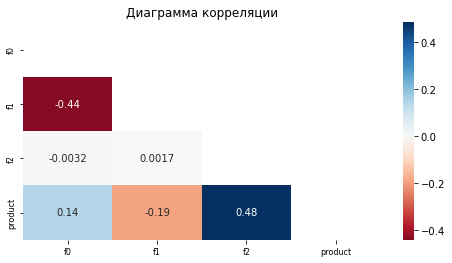

In [4]:
primary_analysis(df1)

### Выводы
---
Датасет содержит 100 тыс. строк и 5 столбцов. Типы данных в каждом столбце корректные. Пропущенных значений в наборе данных нет. Дубликаты отсутствуют. Так как мы не знаем, что стоят за обучающими признаками, то мы не знаем, могут ли они принимать отрицательные значения. Столбец `product` показывает объём запасов в скважине (в тыс. баррелей), запасы могут иссякнуть, но отрицательного значения не могут принять. Минимальное значение в данном столбце - 0, значит, необходимости корректировать значения нет. Высокой корреляции между обучающими признаками нет, мультиколлинеарность в датасете отсутствует.

##### 1.2. Первичный анализ датасета про второй регион

Первые пять строчек датафрема:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Размерность датафрейма:


(100000, 5)


Типы данных в столбцах датафрейма:


id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


Сводная информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Количество дубликатов в датафрейме:


0


Описательная статистика о датафрейме:


,count,mean,std,min,5%,25%,50%,75%,95%,99%,max
f0,100000.0,1.141296,8.965932,-31.609576,-12.706888,-6.298551,1.153055,8.621015,15.024181,18.863531,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-13.190846,-8.267985,-4.813172,-1.332816,3.667425,7.139352,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,-0.002644,1.000021,2.011479,3.999904,5.002640,5.007810,5.019721
product,100000.0,68.825000,45.944423,0.000000,0.000000,26.953261,57.085625,107.813044,137.945408,137.945408,137.945408



Корреляция между столбцами датафрейма:


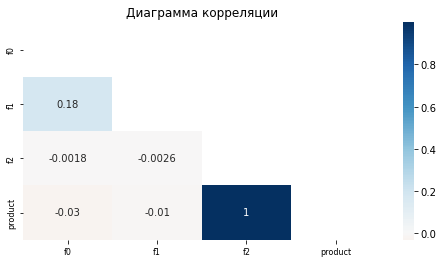

In [5]:
primary_analysis(df2)

### Выводы
---
Аналогично первому датасету, второй набор данных имеет такую же размерность, содержит корректный тип данных в столбцах и не имеет пропущенных значений и дубликатов. Признаки `f0` и `f1` принимают значения из более широкого диапозона, значения стандартных отклонений у этих признаков подтверждают эту мысль. Вызывает опасение то, что между целевым признаком `product` и признаком `f2` корреляция равняется 1.

##### 1.3. Первичный анализ датасета про третий регион

Первые пять строчек датафрема:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



Размерность датафрейма:


(100000, 5)


Типы данных в столбцах датафрейма:


id          object
f0         float64
f1         float64
f2         float64
product    float64
dtype: object


Сводная информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


Количество дубликатов в датафрейме:


0


Описательная статистика о датафрейме:


,count,mean,std,min,5%,25%,50%,75%,95%,99%,max
f0,100000.0,0.002023,1.732045,-8.760004,-2.847974,-1.162288,0.009424,1.158535,2.851247,4.057783,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-2.836316,-1.174820,-0.009482,1.163678,2.845834,4.020189,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,-3.193020,0.130359,2.484236,4.858794,8.227100,10.511973,16.739402
product,100000.0,95.000000,44.749921,0.000000,24.678170,59.450441,94.925613,130.595027,165.665158,184.995815,190.029838



Корреляция между столбцами датафрейма:


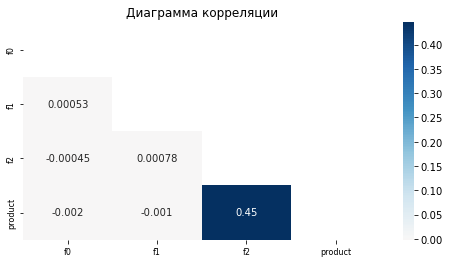

In [6]:
primary_analysis(df3)

Третий датасет аналогичен предыдущим двум по размерности, типу данных в столбцах, пропускам и дубликатам. Разброс в фичах не вызывает опасений, корреляции - нормальные. 

### Шаг 2. Обучение и проверка моделей для каждого региона

##### 2.1. Написание необходимых функций

Так как по условиям задачи необходимо применить только модель линейной регрессии, то спецификация модели будет выглядеть следующий образом:

- $product_i = \beta_1 + \beta_2f0_i + \beta_3f1_i + \beta_4f2_i + \epsilon_i$, где:
    - $product_i$ - объясняемая переменная;
    - $f0_i, f1_i, f2_i$ - набор регрессоров; 
    - $\beta_1, \beta_2, \beta_3, \beta_4$ - коэффициенты при регрессорах;
    - $\epsilon_i$ - случайная составляющая.

В результате мы должны получить оцененную модель следующего вида:
- $\hat{product_i} = \hat{\beta_1} + \hat{\beta_2}f0_i + \hat{\beta_3}f1_i + \hat{\beta_4}f2_i$, 
    - $\hat{product_i}$ - прогнозное значение объясняемой переменной;
    - $f0_i, f1_i, f2_i$ - набор регрессоров;
    - $\hat{\beta_1}, \hat{\beta_2}, \hat{\beta_3}, \hat{\beta_4}$ - оценки коэффициентов при регрессорах.
    
В библиотеке `scikit-learn` в модуле `linear_model` есть функция для оценки линейной модели методом наименьших квадратов `LinearRegression`. В данной функции есть два гиперпараметра:
1. `fit_intercept` - отвечает за наличие свободного коэффициента в модели. В нашей модели это $\beta_1$. По умолчанию значение данного гиперпараметра - `True`. Но мы попробуем задать значение `False`, чтобы посмотреть, как изменится качество модели.

2. `normalize` - отвечает за нормализацию набора регрессоров. По умолчанию значение данного гиперпараметра - `False`. Чтобы изменить его, необходимо самостоятельно нормализовать регрессоры с помощью `StandardScaler()`.

Таким образом, чтобы выполнить все действия, напишем несколько функций:
- `data_split` - возвращает данные, разбитые на обучающую и валидационную выборки;
- `model_evaluation_first` - возвращает оценку модели линейной регрессии с гиперпараметром `fit_intercept` `True`;
- `model_evaluation_second` - возвращает оценку модели линейной регрессии с гиперпараметром `fit_intercept` `False`;
- `data_scale` - возвращает нормализованные данные.

Помимо прочего, мы также посчитаем значение `R2` для каждой модели, чтобы сразу же проверить ее на адекватность.

In [7]:
# из датасета также исключаем стобец id, так как он не понадобится для оценки модели
def data_split(df):
    features = df.drop(["id", "product"], axis = 1)
    target = df["product"]
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                target, test_size = 0.25, random_state = 12345) 
    return features_train, features_valid, target_train, target_valid

In [8]:
def model_evaluation_first(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)

    result = np.sqrt(mean_squared_error(target_valid, predictions_valid))
    r2 = r2_score(target_valid, predictions_valid)
    average_reserves = pd.Series(predictions_valid).mean()

    print("RMSE модели:", "{:,.2f}".format(result))
    print("Коэффициент детерминации:", "{:,.2%}".format(r2))
    print("Средний запас предсказанного сырья:", "{:,.2f}".format(average_reserves), "тыс. баррелей")

In [9]:
def model_evaluation_second(features_train, features_valid, target_train, target_valid):
    model = LinearRegression(fit_intercept = False)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)

    result = np.sqrt(mean_squared_error(target_valid, predictions_valid))
    r2 = r2_score(target_valid, predictions_valid)
    average_reserves = pd.Series(predictions_valid).mean()

    print("RMSE модели:", "{:,.2f}".format(result))
    print("Коэффициент детерминации:", "{:,.2%}".format(r2))
    print("Средний запас предсказанного сырья:", "{:,.2f}".format(average_reserves), "тыс. баррелей") 

In [10]:
def data_scale(features_train, features_valid):
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train_scaled = scaler.transform(features_train)
    features_valid_scaled = scaler.transform(features_valid)
    return features_train_scaled, features_valid_scaled

##### 2.2. Оценка модели для первого региона

In [11]:
df1_features_train, df1_features_valid, df1_target_train, df1_target_valid = data_split(df1)
print(df1_features_train.shape)
print(df1_target_train.shape)
print(df1_features_valid.shape)
print(df1_target_valid.shape)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


In [12]:
model_evaluation_first(df1_features_train, df1_features_valid, df1_target_train, df1_target_valid)

RMSE модели: 37.58
Коэффициент детерминации: 27.99%
Средний запас предсказанного сырья: 92.59 тыс. баррелей


In [13]:
model_evaluation_second(df1_features_train, df1_features_valid, df1_target_train, df1_target_valid)

RMSE модели: 60.44
Коэффициент детерминации: -86.26%
Средний запас предсказанного сырья: 63.16 тыс. баррелей


In [14]:
df1_features_train_scaled, df1_features_valid_scaled = data_scale(df1_features_train, df1_features_valid)

In [15]:
model_evaluation_first(df1_features_train_scaled, df1_features_valid_scaled, df1_target_train, df1_target_valid)

RMSE модели: 37.58
Коэффициент детерминации: 27.99%
Средний запас предсказанного сырья: 92.59 тыс. баррелей


In [16]:
model_evaluation_second(df1_features_train_scaled, df1_features_valid_scaled, df1_target_train, df1_target_valid)

RMSE модели: 99.49
Коэффициент детерминации: -404.74%
Средний запас предсказанного сырья: -0.05 тыс. баррелей


### Выводы
---
В результате все расчетов самой адекватной моделью оказалась самая первая. Нормализация данных никак не повлияла на результаты оценки, а исключение свободного коэффициента привело к ее ухудшению. Наименьшее значение `RMSE` - 37.58, однако коэффициент детерминации всего лишь 0.28. Это означает, что модель предсказывает лучшее, чем простое среднее значение объясняемой переменной, однако она объясняет только 28% разброса в общем разбросе объясняемой переменной. Средний запас предсказанного сырья равняется 92.59 тыс. баррелей.

##### 2.3. Оценка модели для второго региона

In [17]:
df2_features_train, df2_features_valid, df2_target_train, df2_target_valid = data_split(df2)
print(df2_features_train.shape)
print(df2_target_train.shape)
print(df2_features_valid.shape)
print(df2_target_valid.shape)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


In [18]:
model_evaluation_first(df2_features_train, df2_features_valid, df2_target_train, df2_target_valid)

RMSE модели: 0.89
Коэффициент детерминации: 99.96%
Средний запас предсказанного сырья: 68.73 тыс. баррелей


In [19]:
model_evaluation_second(df2_features_train, df2_features_valid, df2_target_train, df2_target_valid)

RMSE модели: 1.21
Коэффициент детерминации: 99.93%
Средний запас предсказанного сырья: 68.33 тыс. баррелей


In [20]:
df2_features_train_scaled, df2_features_valid_scaled = data_scale(df2_features_train, df2_features_valid)

In [21]:
model_evaluation_first(df2_features_train_scaled, df2_features_valid_scaled, df2_target_train, df2_target_valid)

RMSE модели: 0.89
Коэффициент детерминации: 99.96%
Средний запас предсказанного сырья: 68.73 тыс. баррелей


In [22]:
model_evaluation_second(df2_features_train_scaled, df2_features_valid_scaled, df2_target_train, df2_target_valid)

RMSE модели: 68.86
Коэффициент детерминации: -123.88%
Средний запас предсказанного сырья: -0.13 тыс. баррелей


### Выводы
---
Аналогично первому региону во втором регионе лучшей моделью стала самая первая. Исключение свободного коэффициента и нормализация приводят к ухудшению качества модели. `RMSE` - 0.89, коэффициент детерминации равняется практически 100%. Это происходит потому, что корреляция между `f2` и `product` практически равна 1. Средний запас предсказанного сырья: 68.33 тыс. баррелей.

##### 2.4. Оценка модели для третьего региона

In [23]:
df3_features_train, df3_features_valid, df3_target_train, df3_target_valid = data_split(df3)
print(df3_features_train.shape)
print(df3_target_train.shape)
print(df3_features_valid.shape)
print(df3_target_valid.shape)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


In [24]:
model_evaluation_first(df3_features_train, df3_features_valid, df3_target_train, df3_target_valid)

RMSE модели: 40.03
Коэффициент детерминации: 20.52%
Средний запас предсказанного сырья: 94.97 тыс. баррелей


In [25]:
model_evaluation_second(df3_features_train, df3_features_valid, df3_target_train, df3_target_valid)

RMSE модели: 76.65
Коэффициент детерминации: -191.38%
Средний запас предсказанного сырья: 41.60 тыс. баррелей


In [26]:
df3_features_train_scaled, df3_features_valid_scaled = data_scale(df3_features_train, df3_features_valid)

In [27]:
model_evaluation_first(df3_features_train_scaled, df3_features_valid_scaled, df3_target_train, df3_target_valid)

RMSE модели: 40.03
Коэффициент детерминации: 20.52%
Средний запас предсказанного сырья: 94.97 тыс. баррелей


In [28]:
model_evaluation_second(df3_features_train_scaled, df3_features_valid_scaled, df3_target_train, df3_target_valid)

RMSE модели: 103.05
Коэффициент детерминации: -426.70%
Средний запас предсказанного сырья: -0.07 тыс. баррелей


### Выводы
---
Результаты оценки моделей для третьего региона показали такой же тренд, как и у первых двух регионах. Лучшая модель показала `RMSE` в 40.03, но коэффициент детерминации очень низкий. Доля объясненного разброса в общем разбросе объясняемой переменной составляет всего лишь 21%. Это означает, что существует и другие объясняющие регрессоры, которые мы не включили в модель. Средний запас предсказанного сырья равняется 94.97 тыс. баррелей.

##### 2.5. Итоговые модели для каждого региона

По итогам оценок выше мы пришли к выводу, что всех трех регионах лучшей моделью является та, которая содержит в себе свободный коэффициент, а нормализация регрессоров не приводит к изменению результатов, т.е. является лишним действием. Значит, к каждому датасету применим модель со свободным коэффициентом и сохраним прогнозные значения. Для этих целей напишем еще одну функцию `final_model`.  

In [29]:
def final_model(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    predictions_valid = pd.Series(predictions_valid, index = target_valid.index)

    result = np.sqrt(mean_squared_error(target_valid, predictions_valid))
    r2 = r2_score(target_valid, predictions_valid)
    average_reserves = predictions_valid.mean()

    print("RMSE модели:", "{:,.2f}".format(result))
    print("Коэффициент детерминации:", "{:,.2%}".format(r2))
    print("Средний запас предсказанного сырья:", "{:,.2f}".format(average_reserves), "тыс. баррелей")
    
    return result, r2, average_reserves, predictions_valid

In [30]:
df1_result, df1_r2, df1_average_reserves, df1_predictions_valid = final_model(df1_features_train, 
                df1_features_valid, df1_target_train, df1_target_valid)

RMSE модели: 37.58
Коэффициент детерминации: 27.99%
Средний запас предсказанного сырья: 92.59 тыс. баррелей


In [31]:
df2_result, df2_r2, df2_average_reserves, df2_predictions_valid = final_model(df2_features_train, 
                df2_features_valid, df2_target_train, df2_target_valid)

RMSE модели: 0.89
Коэффициент детерминации: 99.96%
Средний запас предсказанного сырья: 68.73 тыс. баррелей


In [32]:
df3_result, df3_r2, df3_average_reserves, df3_predictions_valid = final_model(df3_features_train, 
                df3_features_valid, df3_target_train, df3_target_valid)

RMSE модели: 40.03
Коэффициент детерминации: 20.52%
Средний запас предсказанного сырья: 94.97 тыс. баррелей


### Шаг 3. Подготовка к расчету прибыли

##### 3.1. Сохранение в отдельных переменных ключевых значений для расчетов

In [33]:
#Мы расчитываем прибыль в тысячах рублей за тысячу барелей, поэтому 10 милиардов сохранен таким образом
budget = 1e+07 
chosen_points = 500
best_points = 200
price_per_barrel = 450

##### 3.2.  Рассчет достаточного объёма сырья для безубыточной разработки новой скважины

In [34]:
average_profit_per_point = budget / best_points
print("Средний доход с точки для безубыточной разработки новой скважины:", 
      "{:,.2f}".format(average_profit_per_point), "тыс. руб.")

Средний доход с точки для безубыточной разработки новой скважины: 50,000.00 тыс. руб.


In [35]:
average_barrel_per_point = average_profit_per_point / price_per_barrel
print("Достаточный объём сырья в точке для безубыточной разработки новой скважины:", 
      "{:,.2f}".format(average_barrel_per_point), "тыс. баррелей")

Достаточный объём сырья в точке для безубыточной разработки новой скважины: 111.11 тыс. баррелей


In [36]:
average_barrel_per_region = budget / price_per_barrel
print("Средний объём сырья, необходимый в регионе:", 
      "{:,.2f}".format(average_barrel_per_region), "тыс. баррелей")

Средний объём сырья, необходимый в регионе: 22,222.22 тыс. баррелей


In [37]:
print("Средний запас фактической нефти на скважину в первом регионе", 
      "{:,.2f}".format(df1["product"].mean()), "тыс. баррелей")

Средний запас фактической нефти на скважину в первом регионе 92.50 тыс. баррелей


In [38]:
print("Средний запас фактической нефти на скважину во втором регионе", 
      "{:,.2f}".format(df2["product"].mean()), "тыс. баррелей")

Средний запас фактической нефти на скважину во втором регионе 68.83 тыс. баррелей


In [39]:
print("Средний запас фактической нефти на скважину в третьем регионе", 
      "{:,.2f}".format(df3["product"].mean()), "тыс. баррелей")

Средний запас фактической нефти на скважину в третьем регионе 95.00 тыс. баррелей


### Итог
---
В данном шаге были заданы все необходимые переменные и сохранены их соответствующие значения согласно условиям задачи. Также были посчитаны:
- средний доход с точки для безубыточной разработки новой скважины;
- достаточный объём сырья в точке для безубыточной разработки новой скважины;
- средний запас фактической нефти на скважину в каждом регионе.

### Шаг 4. Написание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели

Напишем функцию `profit_calculation`, которая на вход принимает реальные объёмы запасов в скважине в валидационной выборке, прогнозны по объёмам запасов в скважине и количество таких скважен. Функция сортирует прогнозные значения по убыванию, сохраняет их индексы и из реальных объемов выбирает соответствующие ранее сохраненным индексам значения. По итогу она возвращает посчитанную выручку для региона.

In [40]:
def profit_calculation(real_product, predicted_product, count):
    predict_sorted = predicted_product.sort_values(ascending=False)
    selected = real_product[predict_sorted.index][:count]
    return price_per_barrel * selected.sum() - budget

### Шаг 5. Рассчет рисков и прибыли для каждого региона

In [41]:
state = np.random.RandomState(12345)

def bootstrap(real_product, predicted_product):
    values=[]
    loss = 0
    for i in range(1000):
        real_product_sample = real_product.sample(replace = True, random_state = state, n = chosen_points)
        predicted_product_sample = predicted_product[real_product_sample.index]
        profit = profit_calculation(real_product, predicted_product_sample, best_points)
        if profit < 0:
            loss +=1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = loss / 1000
    return values, average, lower, upper, risk

In [42]:
df1_values, df1_average, df1_lower, df1_upper, df1_risk = bootstrap(df1_target_valid, df1_predictions_valid)
print('Данные по первому региону:')
print('Средняя прибыль по региону = {:,.2f} тыс.руб.'.format(df1_average))
print('95% доверительный интервал от {:,.2f} до {:,.2f} тыс.руб.'.format(df1_lower, df1_upper))
print('Процент риска {:.2%}'.format(df1_risk))

Данные по первому региону:
Средняя прибыль по региону = 396,164.98 тыс.руб.
95% доверительный интервал от -111,215.55 до 909,766.94 тыс.руб.
Процент риска 6.90%


<Figure size 720x360 with 0 Axes>

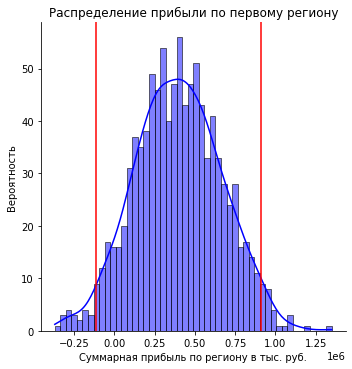

In [43]:
plt.figure(figsize = (10, 5))
sns.displot(df1_values, bins = 50, kde = True, color = 'blue')
plt.axvline(df1_values.quantile(0.025), 0, color = "red") # нижняя граница доверительного интервала
plt.axvline(df1_values.quantile(0.975), 0, color = "red") # верхняя граница доверительного интервала
plt.title('Распределение прибыли по первому региону')
plt.xlabel('Суммарная прибыль по региону в тыс. руб.')
plt.ylabel('Вероятность')
plt.show()

In [44]:
df2_values, df2_average, df2_lower, df2_upper, df2_risk = bootstrap(df2_target_valid, df2_predictions_valid)
print('Данные по второму региону:')
print('Средняя прибыль по региону = {:,.2f} тыс.руб.'.format(df2_average))
print('95% доверительный интервал от {:,.2f} до {:,.2f} тыс.руб.'.format(df2_lower, df2_upper))
print('Процент риска {:.2%}'.format(df2_risk))

Данные по второму региону:
Средняя прибыль по региону = 461,155.82 тыс.руб.
95% доверительный интервал от 78,050.81 до 862,952.06 тыс.руб.
Процент риска 0.70%


<Figure size 720x360 with 0 Axes>

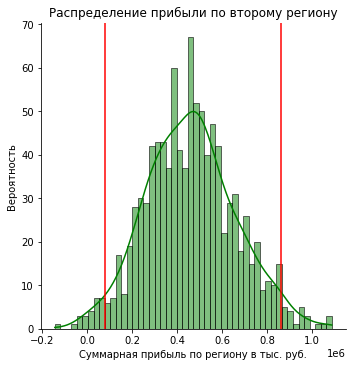

In [45]:
plt.figure(figsize = (10, 5))
sns.displot(df2_values, bins = 50, kde = True, color = 'green')
plt.axvline(df2_values.quantile(0.025), 0, color = "red") # нижняя граница доверительного интервала
plt.axvline(df2_values.quantile(0.975), 0, color = "red") # верхняя граница доверительного интервала
plt.title('Распределение прибыли по второму региону')
plt.xlabel('Суммарная прибыль по региону в тыс. руб.')
plt.ylabel('Вероятность')
plt.show()

In [46]:
df3_values, df3_average, df3_lower, df3_upper, df3_risk = bootstrap(df3_target_valid, df3_predictions_valid)
print('Данные по третьему региону:')
print('Средняя прибыль по региону = {:,.2f} тыс.руб.'.format(df3_average))
print('95% доверительный интервал от {:,.2f} до {:,.2f} тыс.руб.'.format(df3_lower, df3_upper))
print('Процент риска {:.2%}'.format(df3_risk))

Данные по третьему региону:
Средняя прибыль по региону = 392,950.48 тыс.руб.
95% доверительный интервал от -112,227.63 до 934,562.91 тыс.руб.
Процент риска 6.50%


<Figure size 720x360 with 0 Axes>

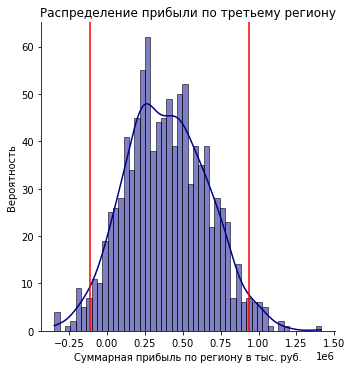

In [47]:
plt.figure(figsize = (10, 5))
sns.displot(df3_values, bins = 50, kde = True, color = 'darkblue')
plt.axvline(df3_values.quantile(0.025), 0, color = "red") # нижняя граница доверительного интервала
plt.axvline(df3_values.quantile(0.975), 0, color = "red") # верхняя граница доверительного интервала
plt.title('Распределение прибыли по третьему региону')
plt.xlabel('Суммарная прибыль по региону в тыс. руб.')
plt.ylabel('Вероятность')
plt.show()

### Выводы
---
В данной работе были проанализированы три регона, были построены модели, которые наилучшим образом прогнозируют объемы запасов в скважинах на основе имеющихся данных, были построены распределения прибыли для каждого региона с помощью Bootstrap.

В результате второй регион показал лучший результат в плане ожидаемой прибыли и возможного уровня риска. Главной причиной стало то, что между `f2` и `product` в датасете есть большая корреляция. Следовательно, прогнозная сила модели получается высокой.

Второй регион лидирует как по значению средней прибыли, так и по уровню риска. 95%-й интервал прогнозируемой прибыли для данного региона не принимает отрицательное значение. Всего лишь 0.7% значений данного распределения принимают отрицательные значения.